In [494]:
import torch
from torch.utils.data import DataLoader # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt

In [495]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [496]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [497]:
# loading the data
train_dataloader = DataLoader(train_data, batch_size=64) # goes over 938 batches of 64
test_dataloader = DataLoader(test_data, batch_size=64)

Name: Pullover, Number: 2


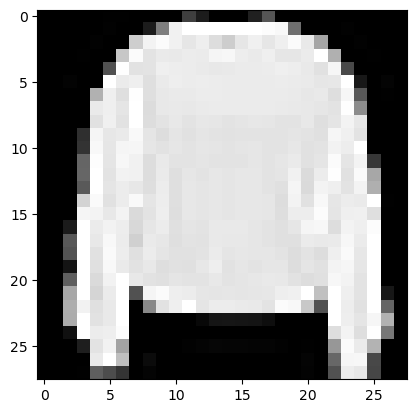

In [498]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [499]:
# flattening the image from 2d to 1d
images = images.view(images.size(0), -1)
print(f"Input (images): {images.shape}\t Output (labels): {labels.shape}")


Input (images): torch.Size([64, 784])	 Output (labels): torch.Size([64])


In [500]:
# implementing MLP

class Neuron:
    # nin is number of inputs
    def __init__(self, nin):
        self.w = torch.rand(nin, requires_grad=True, device="cuda:0")
        self.b = torch.randn(1, requires_grad=True, device="cuda:0")
    
    # x is how many inputs
    def __call__(self, x):
        act = torch.matmul(self.w, x) + self.b  # matrix multiplication with compatible shapes
        # print(sum(act))
        out = torch.tanh(act)
        return out # tensor of 1D with 1 value
    
    def parameters(self):
        return [self.w, self.b]
    
class Layer:
    def __init__(self, nin, nout):
        # create nout neurons with nin inputs
        # the amount of neurons is based on how many outputs we need
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons
    
    # x is how many neurons
    def __call__(self, x):
        # x = torch.as_tensor(x).cuda().clone().requires_grad_(True).float()
        # print(x.grad)
        outs = [n(x) for n in self.neurons]
        # print(self.layers[0].parameters())
        return torch.stack(outs)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # nin is number of inputs
    # nouts is the list of number of outputs/neurons per each layer
    def __init__(self, nin, nouts, lr):
        self.lr = lr
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    # bruh this is forward propagation?? weird
    def __call__(self, x):
        # x = torch.as_tensor(x).cuda().clone().detach().requires_grad_(True).float()
        for layer in self.layers:
            x = layer(x) # x is the input from the other neurons
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        with torch.no_grad():
            for param in self.parameters():
                temp = param.data
                param.data -= self.lr * param.grad
                param.grad.zero_()
                # print(temp, param.data)
    
    def zero_grads(self):
        with torch.no_grad():
            for param in self.parameters():
                print(param.grad)
    

In [501]:
# random_tensor = torch.randn(3, dtype=torch.float32, device="cuda:0")
# labels = torch.randn((2,), dtype=torch.float32, device="cuda:0")

# mlp = MLP(3, [4, 4, 2], lr=0.01)


In [502]:
# b = mlp.parameters()
# a = 0

# for i in range(1600):
#     ypred = mlp(random_tensor)
#     loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(labels, ypred)])

#     loss.backward()

#     mlp.update_parameters()

#     if i % 100 == 0:
#         print(f"Iteration {i}, Loss: {loss.item()}")
    
#     a = mlp.parameters()

# b == a

In [503]:
images, labels = images.to(device), labels.to(device)
labels = labels / 10

In [504]:
mlp = MLP(nin=784, nouts=[4, 4, 1], lr=0.00001)

In [505]:
before_params = [p.clone() for p in mlp.parameters()]

In [506]:
# loss = 0
# for i in range(len(labels)):
#     ypred = mlp(images[i])

#     frac_loss = sum((ypred - labels[i]) ** 2)

#     # loss.backward()

#     # mlp.update_parameters()

#     loss += frac_loss
#     print(loss)


# before_params = mlp.parameters()
after_params = 0

# for epoch in range(1):
#     print(f"Epoch {epoch}")
#     print("-----------------------------")
#     for batch, (x, y) in enumerate(train_dataloader):
#         if batch < 200:
#             x, y = x.to(device), y.to(device)
#             x_flattened = x.view(x.size(0), -1)
            
#             ypred = [sum(mlp(x_img)) for x_img in x_flattened]
#             loss = sum([(yprd - yact) ** 2 for yprd, yact in zip(ypred, y)])

#             # mlp.zero_grads()

#             loss.backward()

#             mlp.update_parameters()

#             if batch % 100 == 0:
#                 print(f"loss: {loss.item()}\t {(batch + 1) * 64}/{len(train_dataloader) * 64}")
            
#             after_params = mlp.parameters()

    # print(loss)

for i in range(1000):

    ypred = [sum(mlp(img)) for img in images]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(labels, ypred)])

    loss.backward()

    mlp.update_parameters()
    after_params = mlp.parameters()
    # print(loss)
    # loss 
# for before, after in zip(before_params, after_params):
#     print(torch.all(before == after))


Name: Coat, Number: 4


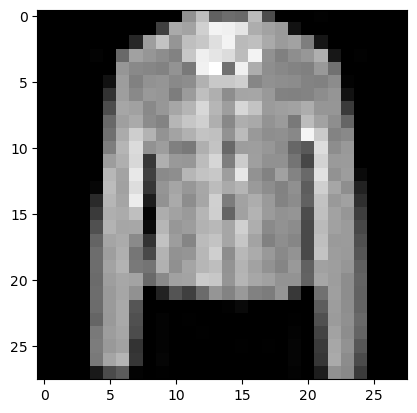

loss: 0.3515852987766266, actual: 0.4000000059604645, predicted: 0.9929463267326355


tensor([[0.9929]], device='cuda:0', grad_fn=<StackBackward0>)

In [507]:
test_images, test_labels = next(iter(test_dataloader))

idx = torch.randint(0, 64, (1,)).item()
test_image = test_images[idx].squeeze()
test_label = test_labels[idx]
print(f"Name: {labels_map[test_label.item()]}, Number: {test_label.item()}")
plt.imshow(test_image, cmap="grey")
plt.show()

test_labels_ = test_labels / 10

test_image = test_image.to("cuda:0")
test_image_flattened = test_image.view(-1)
test_ypred = mlp(test_image_flattened)

test_labels_ = test_labels_.to(device)
test_loss = sum((test_ypred - test_labels_[idx]) ** 2)

print(f"loss: {test_loss.item()}, actual: {test_labels_[idx]}, predicted: {test_ypred.item()}")
# test_image_flattened
test_ypred

In [508]:
# # Evaluate the model on the test set
# with torch.no_grad():
#     ypred_test = [n(x) for x in xs_test]
#     test_loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys_test, ypred_test)])
#     test_loss = test_loss.item()

# print(f"Test Loss: {test_loss}")

# # Print some example predictions and their corresponding actual values
# for i in range(5):
#     print(f"Predicted: {ypred_test[i]}, Actual: {ys_test[i]}")


In [509]:
# for i in range(10000):
#     # Randomly select an index
#     ix = torch.randint(0, 64, (1,)).item()
    
#     # Forward pass through the MLP
#     output = mlp(images[ix]).squeeze()
    
#     # Calculate the loss
#     loss = torch.nn.functional.cross_entropy(output.unsqueeze(0), labels[ix].unsqueeze(0))

#     # Backpropagation
#     loss.backward()

#     # Update parameters
#     mlp.update_parameters()

#     # Print the loss
#     print(f"loss: {loss.item()}")


In [510]:
# i = 0
# for batch, (x, y) in enumerate(train_dataloader):
#     x = x.view(x.size(0), -1)

#     x, y = x.to(device), y.to(device)

#     for img in x:
#         # img.to(device)
#         # print(img.shape)
#         mlp(img)